# Nonlinear Sensor Fusion

In this example the goal is to estimate hidden states of a Dynamical process where all hidden states are Gaussians. Our process can be described with the following two sets of equations:

$$\begin{aligned}
 & p(z_i|z_{i - 1}) = \mathcal{N}(z_{i-1},~\mathcal{I}_{2}),\\
 & p(y_i|z_i)  = \mathcal{N} \left (y_i \left \vert \begin{bmatrix} \| z_{i} - s_{1}\| \\ \|z_{i} - s_{2}\| \\ \|z_{i} - s_{3}\|\end{bmatrix}\!,~\mathcal{I}_{3}\! \right . \right)\!,
\end{aligned}$$

$$\begin{aligned}
 & p(\text{W}) = \text{Wishart}_{2} \\
 & p(\text{R}) = \text{Wishart}_{3} \\
 & p(z_i|z_{i - 1}) = \mathcal{N}(z_{i-1},~W),\\
 & p(y_i|z_i)  = \mathcal{N} \left (y_i \left \vert \begin{bmatrix} \| z_{i} - s_{1}\| \\ \|z_{i} - s_{2}\| \\ \|z_{i} - s_{3}\|\end{bmatrix}\!,~R\! \right . \right)\!,
\end{aligned}$$

where $z_i$ are hidden states, $y_i$ are noisy nonlinear observations. In the second set of the equations, W and R are covariance matrix parameters for z, and y, respectively.

To model this process in `RxInfer`, first, we start with importing all needed packages:

In [1]:
using RxInfer, Random, LinearAlgebra, Distributions, Plots, Flux, DataFrames, DelimitedFiles, StableRNGs

Next step, is to load our data:

In [2]:
sensors = readdlm("data/sensor_fusion/sensors.txt")
sensor1, sensor2, sensor3 = sensors[1,:], sensors[2,:], sensors[3,:]
observation = readdlm("data/sensor_fusion/observation.txt")
position = readdlm("data/sensor_fusion/position.txt")
T = size(observation, 1)
observation_list = [observation[t,:] for t=1:T];

To create a model we use the `@model` macro:

In [3]:
A = [1.0 0.0; 0.0 1.0]
# Nonlinear function that maps states to observations
function f(z)       
    pos = z
    o1 = sqrt(sum((pos-sensor1).^2))
    o2 = sqrt(sum((pos-sensor2).^2))
    o3 = sqrt(sum((pos-sensor3).^2))
    o = [o1,o2,o3]
end

@model function sensor_fusion(T)
    W = diageye(2)
    R = diageye(3)

    z = randomvar(T)
    y = datavar(Vector{Float64}, T)

    z[1] ~ MvNormalMeanCovariance(zeros(2), diageye(2)) 
    y[1] ~ MvNormalMeanCovariance(f(z[1]), diageye(3))

    for t in 2:T
        z[t] ~ MvNormalMeanPrecision(A * z[t-1], W)
        y[t] ~ MvNormalMeanPrecision(f(z[t]), R)
    end

end

In [4]:
@meta function sensor_fusion_meta(nsamples, niterations, rng)
    f(z) -> CVIApproximation(rng, nsamples, niterations, Descent(0.1))
end    

sensor_fusion_meta (generic function with 1 method)

To run inference we will use `inference` function from `RxInfer`.
Note, that for running inference for this model we need to init marginals for z messages.

In [5]:
res_10_10 = inference(
    model = sensor_fusion(T),
    meta = sensor_fusion_meta(1, 3, StableRNG(42)),
    data = (y = observation_list,),
    iterations = 100,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01 * diageye(2)),),
);

In [6]:
res_100_100 = inference(
    model = sensor_fusion(T),
    meta = sensor_fusion_meta(1000, 100, StableRNG(42)),
    data = (y = observation_list,),
    iterations = 100,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01 * diageye(2)),),
);

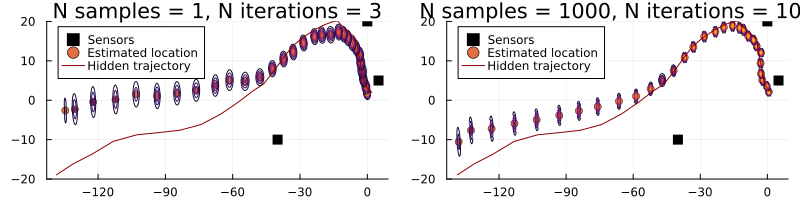

In [7]:
points_10_10 = map(q -> mean(q), res_10_10.posteriors[:z]);
x_10_10 = map(z -> z[1], points_10_10);
y_10_10 = map(z -> z[2], points_10_10);

p1 = plot(title = "N samples = 1, N iterations = 3")

p1 = plot!(p1, [sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]], seriestype = :scatter, color=:black, markersize=5, markershape=:square, label = "Sensors")
p1 = plot!(p1, x_10_10, y_10_10, seriestype = :scatter, label = "Estimated location")

for (index, gaussian) in enumerate(res_10_10.posteriors[:z])
    m1, m2 = mean(gaussian)
    v1, v2 = var(gaussian)
    contour!(p1, range(m1 - 3v1, m1 + 3v1, length = 50), range(m2 - 3v2, m2 + 3v2, length = 50), (x, y) -> pdf(gaussian, [ x, y ]), levels = 10, colorbar = false)
end

p1 = plot!(p1, position'[1:end, 1], position'[1:end, 2], color=:redsblues, label = "Hidden trajectory")
p1 = plot!(p1, legend=:topleft, ylim = (-20, 20))

points_100_100 = map(q -> mean(q), res_100_100.posteriors[:z]);
x_100_100 = map(z -> z[1], points_100_100);
y_100_100 = map(z -> z[2], points_100_100);

p2 = plot(title = "N samples = 1000, N iterations = 100")

p2 = plot!(p2, [sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]], seriestype = :scatter, color=:black, markersize=5, markershape=:square, label = "Sensors")
p2 = plot!(p2, x_100_100, y_100_100, seriestype = :scatter, label = "Estimated location")

for (index, gaussian) in enumerate(res_100_100.posteriors[:z])
    m1, m2 = mean(gaussian)
    v1, v2 = var(gaussian)
    contour!(p2, range(m1 - 3v1, m1 + 3v1, length = 50), range(m2 - 3v2, m2 + 3v2, length = 50), (x, y) -> pdf(gaussian, [ x, y ]), levels = 10, colorbar = false)
end

p2 = plot!(p2, position'[1:end, 1], position'[1:end, 2], color=:redsblues, label = "Hidden trajectory")
p2 = plot!(p2, legend=:topleft, ylim = (-20, 20))

plot(p1, p2, size = (800, 200))

In the following model, please note that covarience are distributions.

In [8]:
@model function sensor_fusion_unfixed_W_R(T)
    W ~ Wishart(3, diageye(2))
    R ~ Wishart(4, diageye(3))

    z = randomvar(T)
    y = datavar(Vector{Float64}, T)

    z[1] ~ MvNormalMeanPrecision(zeros(2), W)
    y[1] ~ MvNormalMeanPrecision(f(z[1]), R)

    for t in 2:T
        z[t] ~ MvNormalMeanPrecision(A * z[t-1], W)
        y[t] ~ MvNormalMeanPrecision(f(z[t]), R)
    end

end

constraints = @constraints begin
    q(z, W, R) = q(z)q(W)q(R)
end;

meta = @meta begin 
    f(z) -> CVIApproximation(StableRNG(42), 2000, 100, Descent(0.01))
end

Meta specification:
  f(z) -> CVIApproximation{StableRNGs.LehmerRNG, Descent}(StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055), 2000, 100, Descent(0.01), false)
Options:
  warn = true

In [9]:
res = inference(
    model = sensor_fusion_unfixed_W_R(T),
    data = (y = observation_list,),
    iterations = 100,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    meta = meta,
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01 * diageye(2)),),
    initmarginals = (R = Wishart(4, diageye(3)), W = Wishart(3, diageye(2)))
);

Looking at the following plot, one can notice that adding additional flexibility gives a better parameter estimation: the founded states fit into the hidden trajectory better.

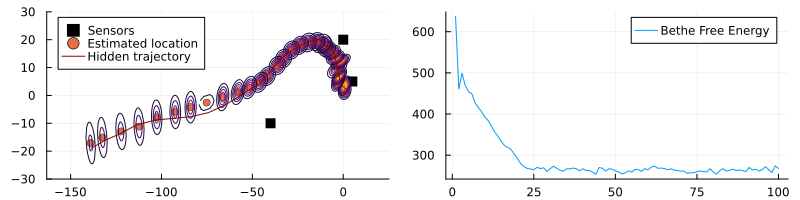

In [10]:
points = map(q -> mean(q), res.posteriors[:z]);
x = map(z -> z[1], points);
y = map(z -> z[2], points);

p = plot()

p = plot!(p, [sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]], seriestype = :scatter, color=:black, markersize=5, markershape=:square, label = "Sensors")
p = plot!(p, x, y, seriestype = :scatter, label = "Estimated location")

for (index, gaussian) in enumerate(res.posteriors[:z])
    m1, m2 = mean(gaussian)
    v1, v2 = var(gaussian)
    contour!(p, range(m1 - 3v1, m1 + 3v1, length = 50), range(m2 - 3v2, m2 + 3v2, length = 50), (x, y) -> pdf(gaussian, [ x, y ]), levels = 10, colorbar = false)
end

p = plot!(p, position'[1:end, 1], position'[1:end, 2], color=:redsblues, label = "Hidden trajectory")
p = plot!(p, legend=:topleft, ylim = (-30, 30))

pfe = plot(res.free_energy, label = "Bethe Free Energy")

plot(p, pfe, size = (800, 200))